In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

dict_labels = train_data.class_to_idx
dict_ids = {v: k for k, v in dict_labels.items()}

100%|██████████| 169001437/169001437 [00:02<00:00, 72683921.53it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


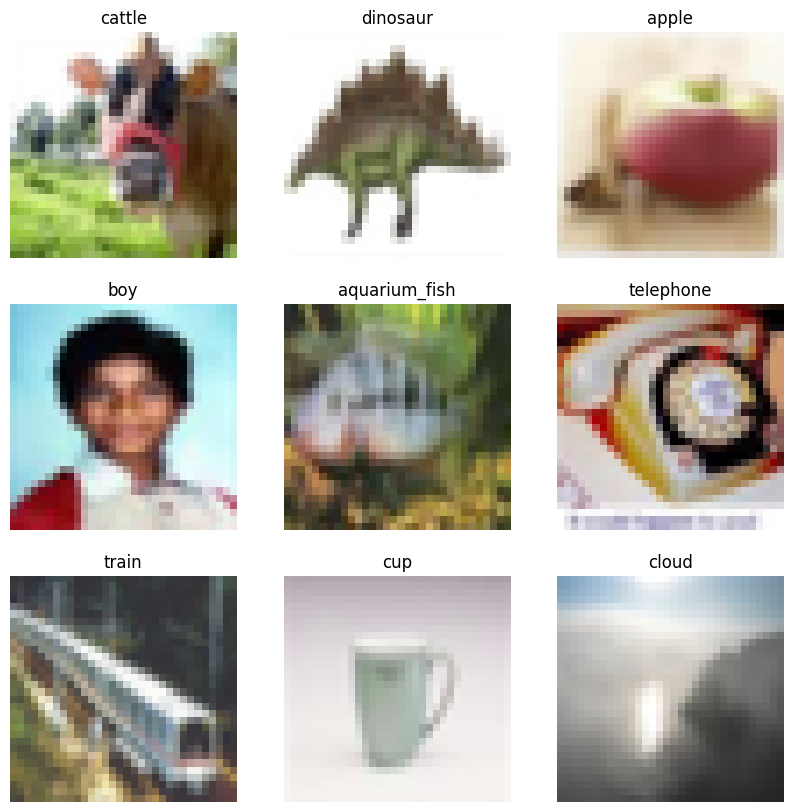

In [3]:
# Visulize 3 x 3 grid of images from the dataset
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    ax[i // 3][i % 3].imshow(train_data[i][0].permute(1, 2, 0))
    ax[i // 3][i % 3].set_title(dict_ids[train_data[i][1]])
    ax[i // 3][i % 3].axis("off")
plt.show()

In [4]:
# Print the number of images in the training and test datasets
print(f'Number of training images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')

# Print the number of classes in the training and test datasets
print(f'Number of classes: {len(dict_labels)}')

# Print the shape of the training and test images
print(f'Shape of training images: {train_data[0][0].shape}')
print(f'Shape of test images: {test_data[0][0].shape}')

Number of training images: 50000
Number of test images: 10000
Number of classes: 100
Shape of training images: torch.Size([3, 32, 32])
Shape of test images: torch.Size([3, 32, 32])


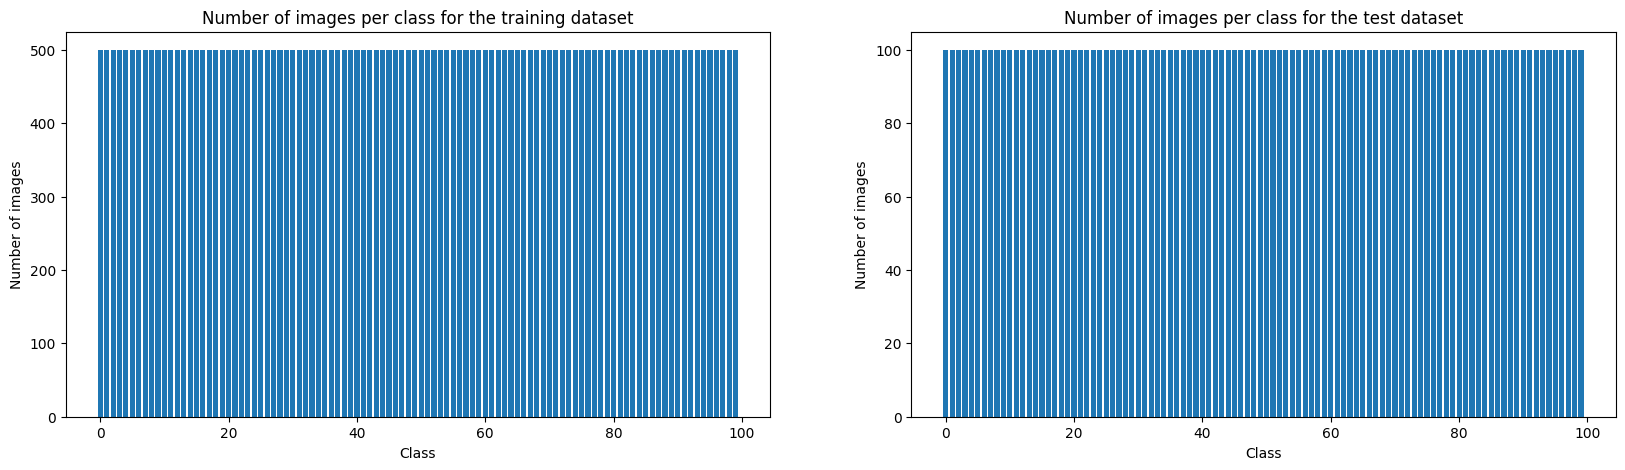

Mean of training images: 500.0
Standard deviation of training images: 0.0


In [5]:
import numpy as np

imgs_class_train = np.bincount(train_data.targets, minlength=len(dict_labels))
imgs_class_test = np.bincount(test_data.targets, minlength=len(dict_labels))

# Plot the number of images per class for the training and test datasets
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].bar(list(dict_ids.keys()), imgs_class_train)
ax[0].set_title('Number of images per class for the training dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of images')
ax[1].bar(list(dict_ids.keys()), imgs_class_test)
ax[1].set_title('Number of images per class for the test dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of images')
plt.show()

# Print the mean and standard deviation of the training images
print(f'Mean of training images: {imgs_class_train.mean()}')
print(f'Standard deviation of training images: {imgs_class_train.std()}')

In [6]:
# Create the transforms
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

# Apply the transforms to a copy of the training dataset and merge it with the original training dataset
train_data_aug = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
train_data = torch.utils.data.ConcatDataset([train_data, train_data_aug])

# Export the new training dataset
torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
torch.save(train_data, './data/train_data_aug.pt')

Files already downloaded and verified


Number of training images: 100000


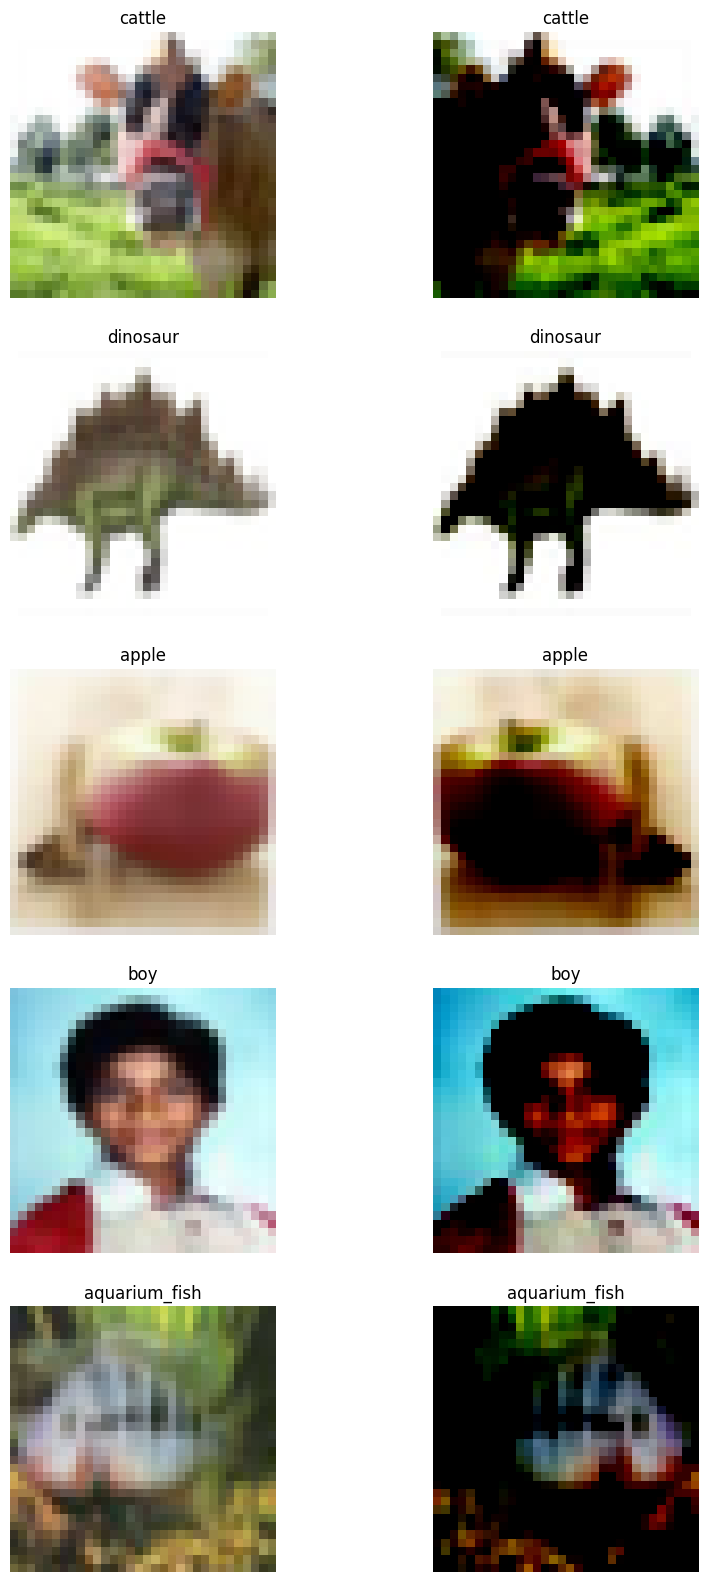

In [7]:
# Verify the number of images in the training dataset
print(f'Number of training images: {len(train_data)}')

# Show the first 5 images with their transformed versions
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    ax[i][0].imshow(train_data[i][0].permute(1, 2, 0))
    ax[i][0].set_title(dict_ids[train_data[i][1]])
    ax[i][0].axis("off")
    ax[i][1].imshow(train_data[i + len(train_data) // 2][0].permute(1, 2, 0))
    ax[i][1].set_title(dict_ids[train_data[i + len(train_data) // 2][1]])
    ax[i][1].axis("off")
plt.show()

In [8]:
# Import libraries and model
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from models.vgg16 import VGG16

In [9]:
# Specify the path to the .pt file
file_path = 'data/train_data_aug.pt'

# Load the train data
try:
    train_data = torch.load(file_path)
except:
    print('File not found. Please, run the _data_ notebook first.')

# Load the test data
test_data = datasets.CIFAR100(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Create a dictionary to map the labels to the class names
dict_labels = test_data.class_to_idx
dict_ids = {v: k for k, v in dict_labels.items()}

Files already downloaded and verified


Number of training images: 100000


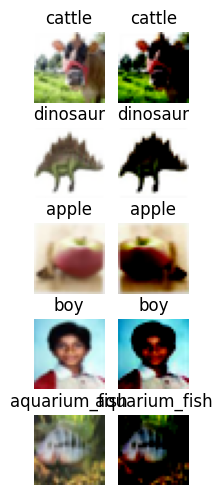

In [10]:
# Verify the number of images in the training dataset
print(f'Number of training images: {len(train_data)}')

# Show the first 5 images with their transformed versions
fig, ax = plt.subplots(5, 2, figsize=(2, 6))
for i in range(5):
    ax[i][0].imshow(train_data[i][0].permute(1, 2, 0))
    ax[i][0].set_title(dict_ids[train_data[i][1]])
    ax[i][0].axis("off")
    ax[i][1].imshow(train_data[i + len(train_data) // 2][0].permute(1, 2, 0))
    ax[i][1].set_title(dict_ids[train_data[i + len(train_data) // 2][1]])
    ax[i][1].axis("off")
plt.show()

In [11]:
# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Verify the size of the data loaders
print(f'Number of batches in the train loader: {len(train_loader)}')
print(f'Number of batches in the test loader: {len(test_loader)}')

Number of batches in the train loader: 1563
Number of batches in the test loader: 157


In [12]:
def train_model(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    epochs: int,
    device: str = "cpu",
) -> None:
    """
    Make backpropagation and update the parameters of the model.

    Parameters
    ----------
    model : nn.Module
        The model to train.
    dataloader : torch.utils.data.DataLoader
        The dataset to use for training.
    epochs : int

        The number of epochs to train the model.
    device : str
        The device to use for training.
    """
    # Verify that model has parameters and methods
    atributes_needed = [
        "loss",
        "actual_loss",
        "actual_corrects",
        "cost",
        "epochs_printed",
        "acc",
    ]
    methods_needed = ["forward", "backward"]
    for atribute in atributes_needed:
        assert hasattr(
            model, atribute
        ), f"Model does not have the attribute {atribute}."
    for method in methods_needed:
        assert hasattr(model, method), f"Model does not have the method {method}."

    # If all ok, show message
    print("✅ Model has all the needed parameters and methods.")

    # Train
    for epoch in range(epochs):
        model.actual_loss = 0
        model.actual_corrects = 0

        for batch in dataloader:
            x, y = batch
            model.actual_loss += model.backward(x.to(device), y.to(device), epoch)

        model.acc.append(model.actual_corrects / (len(dataloader) * batch_size))
        model.cost.append(model.actual_loss / (len(dataloader) * batch_size))
        print(
            f"Epoch {epoch + 1} - Cost: {model.cost[-1]:.4f} | Acc: {model.acc[-1]:.4f}"
        )
        print("-" * 50)

In [18]:
def plot_cost_acc(model: nn.Module) -> None:
    """
    Plot the cost and accuracy of the model.

    Parameters
    ----------
    model : nn.Module
        The model to plot.

    Returns
    -------
    None
        The plot of the cost and accuracy of the model.
    """
    # Verify that model has parameters and methods
    atributes_needed = [
        "cost",
        "acc",
    ]
    for atribute in atributes_needed:
        assert hasattr(
            model, atribute
        ), f"Model does not have the attribute {atribute}."

    # Plot cost and accuracy
    fig, ax1 = plt.subplots()

    cost = model.cost
    acc = model.acc

    color = "tab:red"
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Cost", color=color)
    ax1.plot(cost, color=color)
    ax1.tick_params(axis="y", labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = "tab:blue"
    ax2.set_ylabel("Accuracy", color=color)
    ax2.plot(acc, color=color)
    ax2.tick_params(axis="y", labelcolor=color)

    fig.tight_layout()
    plt.show()

Device: cuda
✅ Model has all the needed parameters and methods.


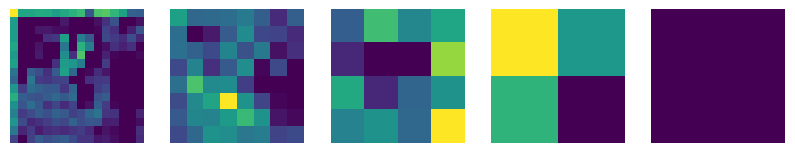

Epoch 1 - Cost: 0.0634 | Acc: 0.0747
--------------------------------------------------


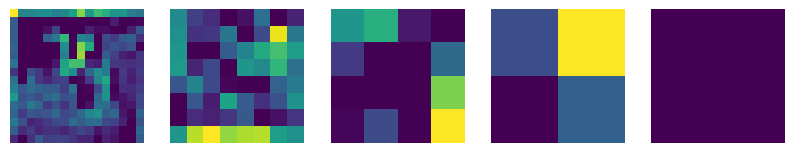

Epoch 2 - Cost: 0.0496 | Acc: 0.2035
--------------------------------------------------


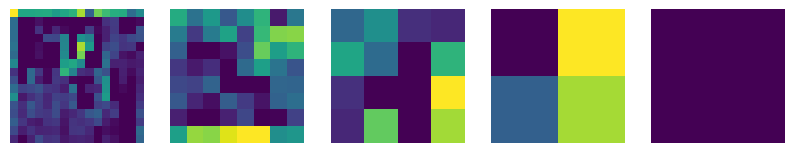

Epoch 3 - Cost: 0.0400 | Acc: 0.3199
--------------------------------------------------


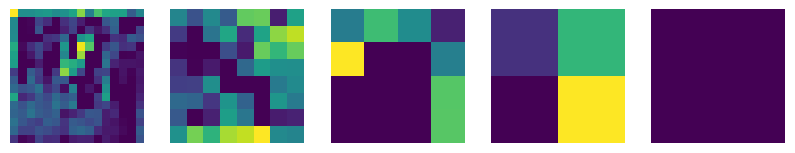

Epoch 4 - Cost: 0.0331 | Acc: 0.4187
--------------------------------------------------


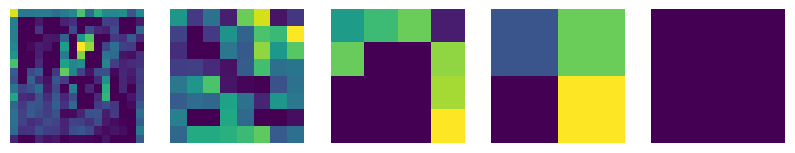

Epoch 5 - Cost: 0.0277 | Acc: 0.4978
--------------------------------------------------


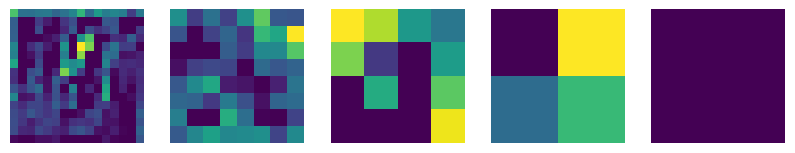

Epoch 6 - Cost: 0.0232 | Acc: 0.5699
--------------------------------------------------


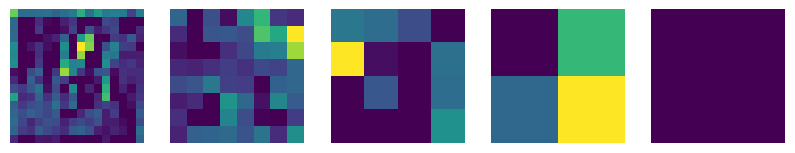

Epoch 7 - Cost: 0.0195 | Acc: 0.6330
--------------------------------------------------


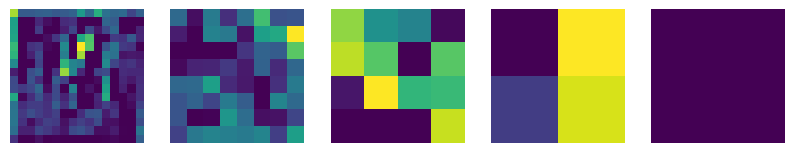

Epoch 8 - Cost: 0.0162 | Acc: 0.6891
--------------------------------------------------


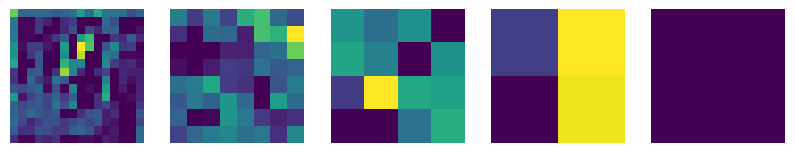

Epoch 9 - Cost: 0.0137 | Acc: 0.7345
--------------------------------------------------


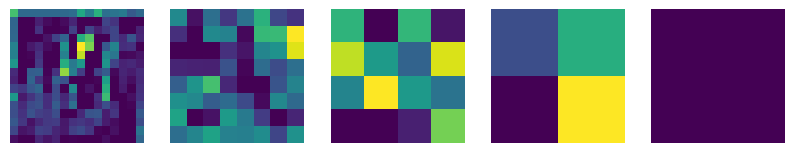

Epoch 10 - Cost: 0.0115 | Acc: 0.7773
--------------------------------------------------


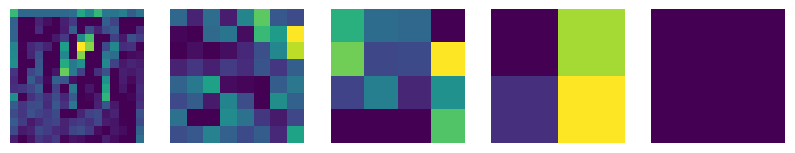

Epoch 11 - Cost: 0.0097 | Acc: 0.8113
--------------------------------------------------


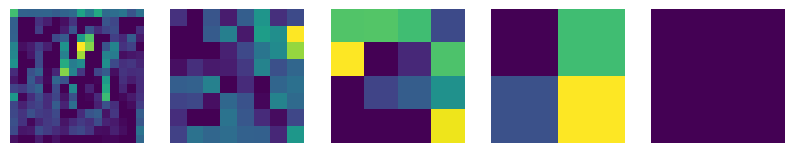

Epoch 12 - Cost: 0.0083 | Acc: 0.8398
--------------------------------------------------


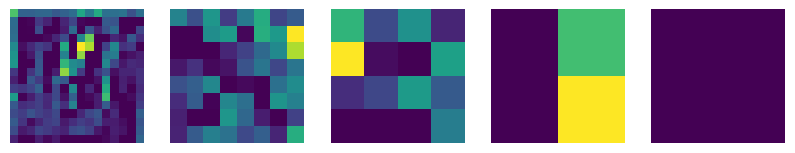

Epoch 13 - Cost: 0.0070 | Acc: 0.8647
--------------------------------------------------


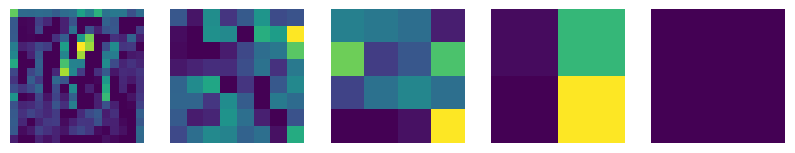

Epoch 14 - Cost: 0.0059 | Acc: 0.8858
--------------------------------------------------


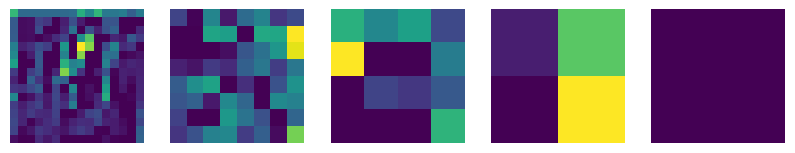

Epoch 15 - Cost: 0.0052 | Acc: 0.9003
--------------------------------------------------


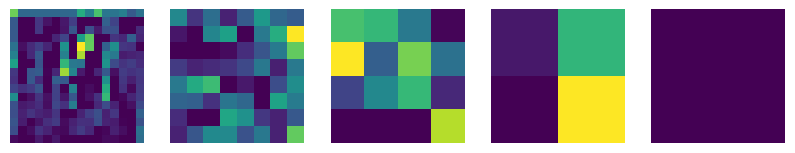

Epoch 16 - Cost: 0.0045 | Acc: 0.9136
--------------------------------------------------


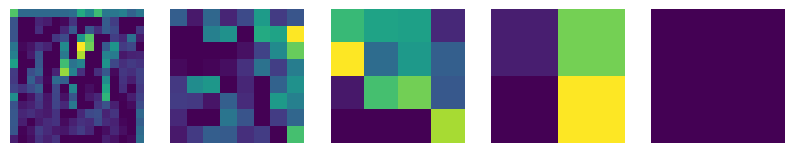

Epoch 17 - Cost: 0.0039 | Acc: 0.9254
--------------------------------------------------


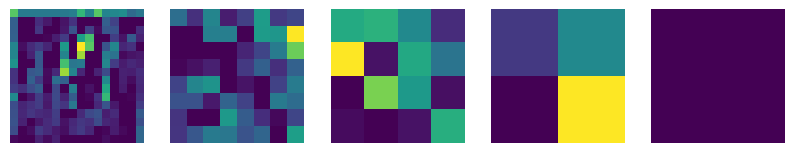

Epoch 18 - Cost: 0.0033 | Acc: 0.9354
--------------------------------------------------


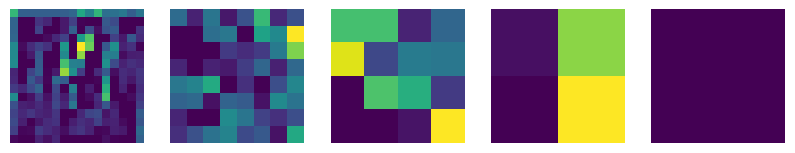

Epoch 19 - Cost: 0.0031 | Acc: 0.9399
--------------------------------------------------


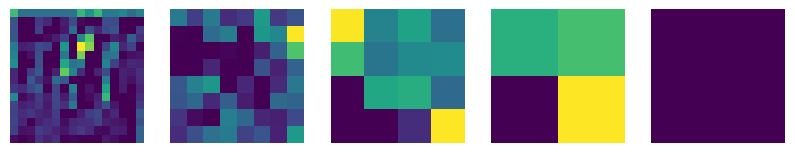

Epoch 20 - Cost: 0.0026 | Acc: 0.9484
--------------------------------------------------


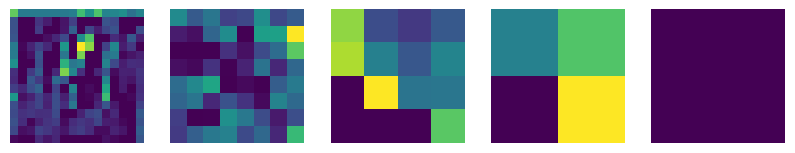

Epoch 21 - Cost: 0.0024 | Acc: 0.9531
--------------------------------------------------


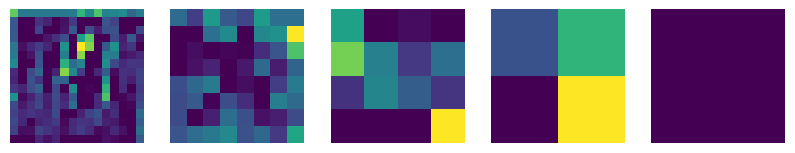

Epoch 22 - Cost: 0.0021 | Acc: 0.9593
--------------------------------------------------


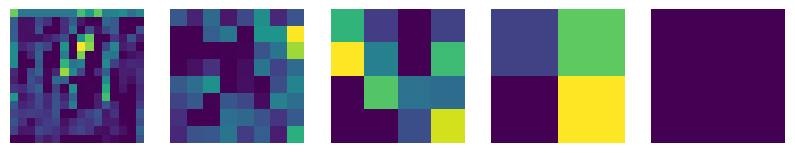

Epoch 23 - Cost: 0.0018 | Acc: 0.9636
--------------------------------------------------


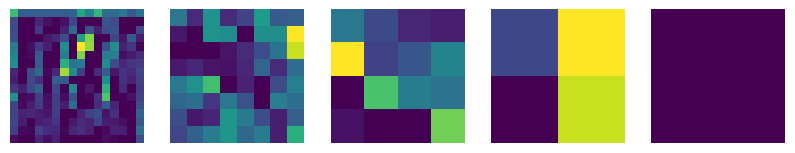

Epoch 24 - Cost: 0.0017 | Acc: 0.9656
--------------------------------------------------


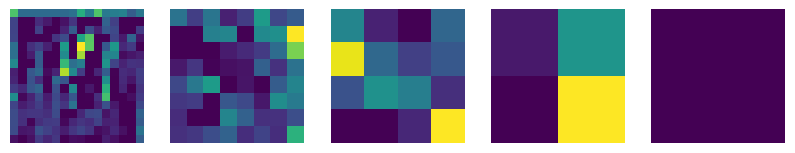

Epoch 25 - Cost: 0.0015 | Acc: 0.9701
--------------------------------------------------


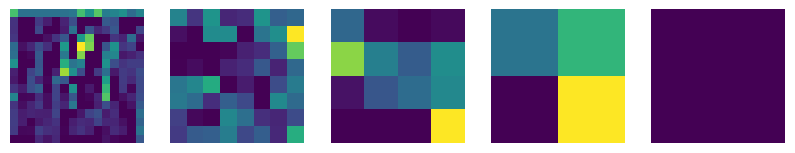

Epoch 26 - Cost: 0.0014 | Acc: 0.9719
--------------------------------------------------


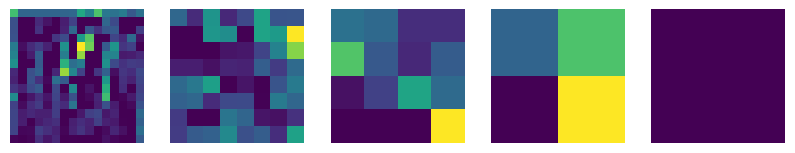

Epoch 27 - Cost: 0.0013 | Acc: 0.9736
--------------------------------------------------


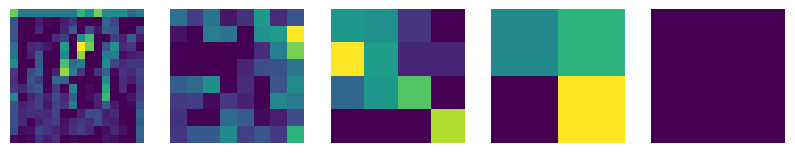

Epoch 28 - Cost: 0.0012 | Acc: 0.9767
--------------------------------------------------


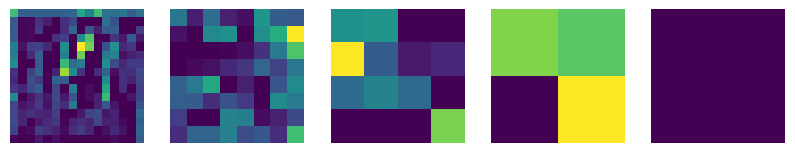

Epoch 29 - Cost: 0.0010 | Acc: 0.9788
--------------------------------------------------


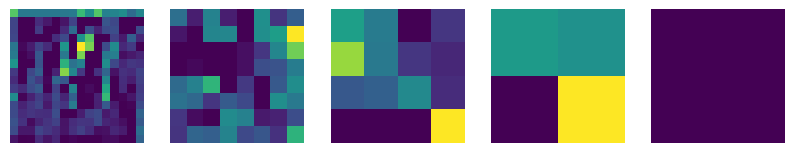

Epoch 30 - Cost: 0.0010 | Acc: 0.9796
--------------------------------------------------


In [14]:
# Import the model
model_vgg16 = VGG16()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

model_vgg16.to(device)  # Move the model to the desired device

train_model(model_vgg16, train_loader, 30, device)

In [15]:
print(model_vgg16.acc)

# Mostrar el coste y la precisión
# plot_cost_acc(model_vgg16)

[tensor(0.0747, device='cuda:0'), tensor(0.2035, device='cuda:0'), tensor(0.3199, device='cuda:0'), tensor(0.4187, device='cuda:0'), tensor(0.4978, device='cuda:0'), tensor(0.5699, device='cuda:0'), tensor(0.6330, device='cuda:0'), tensor(0.6891, device='cuda:0'), tensor(0.7345, device='cuda:0'), tensor(0.7773, device='cuda:0'), tensor(0.8113, device='cuda:0'), tensor(0.8398, device='cuda:0'), tensor(0.8647, device='cuda:0'), tensor(0.8858, device='cuda:0'), tensor(0.9003, device='cuda:0'), tensor(0.9136, device='cuda:0'), tensor(0.9254, device='cuda:0'), tensor(0.9354, device='cuda:0'), tensor(0.9399, device='cuda:0'), tensor(0.9484, device='cuda:0'), tensor(0.9531, device='cuda:0'), tensor(0.9593, device='cuda:0'), tensor(0.9636, device='cuda:0'), tensor(0.9656, device='cuda:0'), tensor(0.9701, device='cuda:0'), tensor(0.9719, device='cuda:0'), tensor(0.9736, device='cuda:0'), tensor(0.9767, device='cuda:0'), tensor(0.9788, device='cuda:0'), tensor(0.9796, device='cuda:0')]


In [19]:
tensores_cpu = []
for tensor in model_vgg16.acc:
  tensores_cpu.append(tensor.contiguous().cpu())
model_vgg16.acc = tensores_cpu

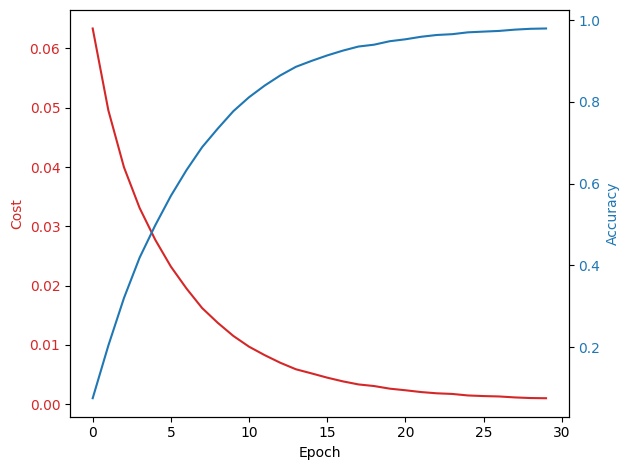

In [20]:
plot_cost_acc(model_vgg16)

In [21]:
# Exportar modelo
torch.save(model_vgg16.state_dict(), 'models/vgg16.pt')